In [2]:
import gc
import os
import random
import sys
import time
import math

import nltk
import torch.nn as nn

import pandas as pd
import torch
from PIL import Image
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
from torch import optim
from torch.optim.lr_scheduler import ExponentialLR, StepLR
from torchvision import transforms
import re
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch.nn.functional as F
from collections import defaultdict
from itertools import product
from textblob import TextBlob

warnings.filterwarnings("ignore", category=UserWarning)  # Disable UserWarnings
tqdm.pandas()

In [5]:
all_labels = [random.randint(0, 1) for _ in range(10)]
all_preds = [random.randint(0, 1) for _ in range(10)]
print(all_labels)
print(all_preds)
print(accuracy_score(all_labels, all_preds))

[0, 0, 1, 1, 0, 1, 0, 0, 0, 0]
[1, 0, 1, 0, 1, 1, 0, 0, 1, 0]
0.6


In [492]:
train_df = pd.read_csv("./dataset/train.csv")
test_df = pd.read_csv("./dataset/test.csv")
validation_df = pd.read_csv("./dataset/val.csv")

In [493]:
import text_preprocessing

train_df['preprocessed_text'] = train_df['caption'].progress_apply(text_preprocessing.text_preparetion_simple)
validation_df['preprocessed_text'] = validation_df['caption'].progress_apply(text_preprocessing.text_preparetion_simple)
test_df['preprocessed_text'] = test_df['caption'].progress_apply(text_preprocessing.text_preparetion_simple)

100%|██████████| 2000/2000 [00:00<00:00, 500006.44it/s]


In [494]:
train_df

,id,caption,image_id,label,preprocessed_text
0,417812c5-0ce4-499d-b97d-4d28827239bc,Wet elephants shake water onto people bathing ...,394330,0,wet elephants shake water onto people bathing ...
1,5ac91fa3-55f2-4cb3-8c8f-ad84f78e6b36,Two men holding tennis racquets on the court,130849,0,two men holding tennis racquets on the court
2,d2705b90-8347-4cab-a7a6-654540d9a489,A bird on a tree limb with mountains in the ba...,514790,0,a bird on a tree limb with mountains in the ba...
3,a3b33fe7-3085-4433-9c18-8814803891b4,A kitchen and dining room are featured along w...,182096,0,a kitchen and dining room are featured along w...
4,1514b0e4-0665-45bc-ab32-52fce326cc29,A fruit stand has various fruits on the table.,68788,1,a fruit stand has various fruits on the table
...,...,...,...,...,...
9995,1d1df243-485d-4b29-82c8-7e34c0de1f5c,Several people stand in a field flying a kite.,522702,0,several people stand in a field flying a kite
9996,f7dfa883-e524-4974-b5ba-6b3c3db49087,A batter hitting a pitch at a baseball game.,441874,1,a batter hitting a pitch at a baseball game
9997,602e83dc-6539-4c1a-8d19-c1481b5c24bf,A person on white surfboard next to group in a...,166716,0,a person on white surfboard next to group in a...
9998,d9ce2e8c-0831-466a-8756-4c40d772b1ce,A baseball player getting ready to swing at th...,517601,0,a baseball player getting ready to swing at th...


In [495]:
train_df


def build_simple_vocab(sentences, special_tokens=None):
    """
    Manually create a vocabulary from a list of tokenized sentences.
    
    Args:
        sentences (list of str): List of sentences to build vocabulary from.
        special_tokens (list of str): Special tokens like <pad>, <unk>.
        
    Returns:
        dict: A vocabulary mapping tokens to indices.
        dict: An inverse vocabulary mapping indices to tokens.
    """
    special_tokens = special_tokens or ['<pad>', '<unk>']
    vocab = defaultdict(lambda: len(vocab))  # Default index is the current vocab size
    for token in special_tokens:
        vocab[token]  # Add special tokens first

    # Add tokens from sentences
    for sentence in sentences:
        for token in nltk.word_tokenize(sentence):
            if token.strip():  # Exclude empty tokens
                vocab[token]

    # Convert to a normal dict (no longer dynamic)
    vocab = dict(vocab)
    inverse_vocab = {index: token for token, index in vocab.items()}
    return vocab, inverse_vocab


# Vectorize a sentence
def vectorize_sentence(sentence, vocab):
    """
    Converts a sentence into a tensor of token indices using a given vocabulary,
    ignoring empty tokens.
    
    Args:
        sentence (str): Input sentence.
        vocab (Vocab): Vocabulary to map tokens to indices.
        
    Returns:
        torch.Tensor: Vectorized sentence as a tensor.
    """
    # Ensure '<unk>' exists in the vocabulary
    unk_idx = vocab.get('<unk>', -1)
    if unk_idx == -1:
        raise ValueError("The vocabulary must include '<unk>' for unknown tokens.")

    # Split sentence into tokens and map them to indices
    tokens = [token for token in sentence.split() if token.strip()]
    return torch.tensor([vocab.get(token, unk_idx) for token in tokens], dtype=torch.long)



# Custom Dataset Class
class PreprocessingDataset(Dataset):
    def __init__(self, dataframe, vocab, images_path, train=True, max_len=None, augmentation_prob=0.3):
        """
        Dataset for preprocessing image-text pairs with TF-IDF vectorization.

        Args:
            dataframe (pd.DataFrame): DataFrame containing 'image_id', 'sentence', and optionally 'label'.
            vectorizer (TfidfVectorizer): TF-IDF vectorizer for text.
            images_path (str): Base path to the images.
            train (bool): Whether this is a training dataset.
            max_len (int): Maximum length for sentences in terms of features. Truncation isn't typical with TF-IDF.
        """
        super().__init__()
        self.dataframe = dataframe
        self.vocab = vocab
        self.train = train
        self.max_len = max_len
        self.images_path = images_path
        self.augmentation_prob = augmentation_prob
        # Define image transformations
        self.image_transform = transforms.Compose([
            transforms.RandomResizedCrop(100, scale=(0.8, 1.0)),
            # transforms.RandomVerticalFlip(),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]

        # Process sentence
        sentence = row['caption']
        if random.random() < self.augmentation_prob:
            # sentence = self.augment_text(sentence)
            sentence = self.synonym_replacement(sentence)
        vectorized_sentence = vectorize_sentence(sentence, self.vocab)

        # Pad or truncate the sentence
        if len(vectorized_sentence) < self.max_len:
            padding_length = self.max_len - len(vectorized_sentence)
            pad_tensor = torch.full((padding_length,), self.vocab['<pad>'], dtype=torch.long)
            vectorized_sentence = torch.cat((vectorized_sentence, pad_tensor), dim=0)
        else:
            vectorized_sentence = vectorized_sentence[:self.max_len]

        # Process image
        image_path = f"{self.images_path}{row['image_id']}.jpg"
            
        try:
            image = Image.open(image_path).convert("RGB")  # Convert to RGB
            image = self.image_transform(image)
        except FileNotFoundError:
            raise FileNotFoundError(f"Image not found at path: {image_path}")

        # Handle labels (for training)
        if self.train:
            label = row['label']
            label = torch.tensor(label, dtype=torch.long)
            return {
                'images': image,
                'captions': vectorized_sentence,
                'labels': label
            }
        else:
            return {
                'images': image,
                'captions': vectorized_sentence,
                'id': row['id']
            }

    def augment_text(self, text):
        """ Augment text using synonym replacement and rephrasing. """
        if random.random() < 0.5:
            return self.synonym_replacement(text)
        else:
            return self.rephrase_text(text)


    def synonym_replacement(self, text):
        # Tokenize the sentence
        words = nltk.word_tokenize(text)
        new_words = words.copy()
    
        # Find indices of words that can be replaced
        replaceable = [i for i, word in enumerate(words) if wordnet.synsets(word)]
        
        # Randomly choose half of these words to replace
        num_to_replace = len(replaceable) // 2
        chosen_indices = random.sample(replaceable, num_to_replace)
    
        # Replace chosen words with synonyms
        for i in chosen_indices:
            synsets = wordnet.synsets(words[i])
            if synsets:
                # Choose a random synonym from the first synset
                synonyms = list(set([lemma.name() for lemma in synsets[0].lemmas() if lemma.name() != words[i]]))
                if synonyms:
                    new_words[i] = random.choice(synonyms).replace('_', ' ')

        # Reconstruct the sentence
        return ' '.join(new_words)


    def rephrase_text(self, text):
        blob = TextBlob(text)
        return str(blob.correct())

In [496]:
tokenized_sentence = [nltk.word_tokenize(sentence) for sentence in train_df['preprocessed_text']]
max_len = max(len([token for token in sentence.split(" ")]) for sentence in train_df['preprocessed_text'])
print(max_len)
vocab, inverse_vocab = build_simple_vocab(train_df['preprocessed_text'])

46


In [497]:
train_dataset = PreprocessingDataset(train_df, vocab, images_path = "./dataset/train_images/", train=True, max_len=max_len)
val_dataset = PreprocessingDataset(validation_df, vocab, images_path = "./dataset/val_images/", train=True, max_len=max_len)
test_dataset = PreprocessingDataset(test_df, vocab, images_path = "./dataset/test_images/", train=False, max_len=max_len)

In [498]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [499]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [500]:
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.LeakyReLU(),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [501]:
class CBAM(nn.Module):
    def __init__(self, channel, reduction=16, kernel_size=7):
        super(CBAM, self).__init__()
        # Channel attention module
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.AdaptiveMaxPool2d(1),
            nn.Conv2d(channel, channel // reduction, 1, bias=False),
            nn.LeakyReLU(),
            nn.Conv2d(channel // reduction, channel, 1, bias=False),
            nn.Sigmoid()
        )
        # Spatial attention module
        self.spatial_attention = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size, padding=(kernel_size // 2), bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Channel attention
        avg_out = self.channel_attention[0](x)
        max_out = self.channel_attention[1](x)
        out = self.channel_attention[2:](avg_out + max_out)
        x = x * out
        
        # Spatial attention
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        spatial = torch.cat([avg_out, max_out], dim=1)
        spatial = self.spatial_attention(spatial)
        return x * spatial

In [502]:
class ECABlock(nn.Module):
    def __init__(self, channel, gamma=2, b=1):
        super(ECABlock, self).__init__()
        self.gamma = gamma
        self.b = b
        self.conv = None

    def forward(self, x):
        b, c, h, w = x.size()
        t = int(abs((torch.log2(torch.tensor(c, dtype=torch.float)) + self.b) / self.gamma))
        k = t if t % 2 else t + 1
        self.conv = nn.Conv1d(1, 1, kernel_size=k, padding=(k - 1) // 2, bias=False)

        y = torch.mean(x, dim=(2, 3), keepdim=True)  # Global Average Pooling
        y = y.squeeze(-1).permute(0, 2, 1)  # [B, C, 1] -> [B, 1, C]
        y = self.conv(y).permute(0, 2, 1).unsqueeze(-1)  # [B, 1, C] -> [B, C, 1]
        y = torch.sigmoid(y)
        return x * y.expand_as(x)

In [503]:
class CNN(nn.Module):
    def __init__(self, cnn_dropout_value):
        super(CNN, self).__init__()
        

        self.CNN_block = nn.Sequential(
            self.CNN2d_block(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1, cnn_dropout_value=cnn_dropout_value),
            self.CNN2d_block(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1, cnn_dropout_value=cnn_dropout_value),
            self.CNN2d_block(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1, cnn_dropout_value=cnn_dropout_value),
            self.CNN2d_block(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1, cnn_dropout_value=cnn_dropout_value),
            

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(cnn_dropout_value),
            SEBlock(64),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.flatten = nn.Flatten()

    def forward(self, images):
        img_features = self.CNN_block(images)  
        img_features = self.flatten(img_features)  
        return img_features
    
    def CNN2d_block(self, in_channels, out_channels, kernel_size, stride, padding, cnn_dropout_value):
        return nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.LeakyReLU(),
            nn.BatchNorm2d(out_channels),
            nn.Dropout(cnn_dropout_value),
            SEBlock(out_channels),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

In [504]:
class SEBlock1D(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock1D, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.LeakyReLU(),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        return x * y.expand_as(x)

In [505]:
class CBAM1d(nn.Module):
    def __init__(self, channel, reduction=16, kernel_size=7):
        super(CBAM1d, self).__init__()
        # Channel attention
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.AdaptiveMaxPool1d(1),
            nn.Conv1d(channel, channel // reduction, 1, bias=False),
            nn.LeakyReLU(),
            nn.Conv1d(channel // reduction, channel, 1, bias=False),
            nn.Sigmoid()
        )
        # Temporal (spatial) attention
        self.temporal_attention = nn.Sequential(
            nn.Conv1d(2, 1, kernel_size, padding=(kernel_size // 2), bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Channel attention
        avg_out = self.channel_attention[0](x)
        max_out = self.channel_attention[1](x)
        out = self.channel_attention[2:](avg_out + max_out)
        x = x * out
        
        # Temporal attention
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        temporal = torch.cat([avg_out, max_out], dim=1)
        temporal = self.temporal_attention(temporal)
        return x * temporal

In [506]:
class ECA1d(nn.Module):
    def __init__(self, channel, gamma=2, b=1):
        super(ECA1d, self).__init__()
        self.gamma = gamma
        self.b = b
        self.conv = None

    def forward(self, x):
        b, c, t = x.size()
        t = int(abs((torch.log2(torch.tensor(c, dtype=torch.float32)) + self.b) / self.gamma))
        k = t if t % 2 else t + 1
        self.conv = nn.Conv1d(1, 1, kernel_size=k, padding=(k - 1) // 2, bias=False)

        y = torch.mean(x, dim=2, keepdim=True)  # Global Average Pooling
        y = self.conv(y.squeeze(-1).unsqueeze(1))  # [B, C, 1] -> [B, 1, C]
        y = torch.sigmoid(y).squeeze(1).unsqueeze(2)  # [B, 1, C] -> [B, C, 1]
        return x * y.expand_as(x)


In [507]:
class PositionalEncoding(nn.Module):
    def __init__(self, embedding_dim, max_len):
        super(PositionalEncoding, self).__init__()
        # Create a matrix of shape (max_len, embedding_dim) for positional encodings
        position = torch.arange(0, max_len).unsqueeze(1)  # Shape: (max_len, 1)
        div_term = torch.exp(torch.arange(0, embedding_dim, 2) * (-math.log(float(max_len)) / embedding_dim))
        
        pe = torch.zeros(max_len, embedding_dim)  # Shape: (max_len, embedding_dim)
        pe[:, 0::2] = torch.sin(position * div_term)  # Sin for even indices
        pe[:, 1::2] = torch.cos(position * div_term)  # Cos for odd indices
        
        pe = pe.unsqueeze(0)  # Add batch dimension: (1, max_len, embedding_dim)
        self.register_buffer('pe', pe)  # Register as non-learnable buffer

    def forward(self, x):
        """
        Add positional encoding to the input embeddings.
        x: (Batch, SeqLen, EmbeddingDim)
        """
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len, :].to(x.device)

In [508]:
class TextModule(nn.Module):
    def __init__(self, cnn_dropout_value, vocab_size, embedding_dim=64):
        super(TextModule, self).__init__()

        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim, padding_idx=vocab["<pad>"])
        self.positional_encoding = PositionalEncoding(embedding_dim=embedding_dim, max_len=max_len)

        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=embedding_dim,
                nhead=8,
                dim_feedforward=128,
                dropout=cnn_dropout_value*2,
                activation='relu',
                batch_first=True,
            ),
            num_layers=5
        )

    def forward(self, captions):
        embedded_captions = self.embedding(captions)
        pos_encoded_captions = self.positional_encoding(embedded_captions)  # (Batch, SeqLen, EmbeddingDim)
        
        # ##### TEST POSITIONAL ENCODING #####
        # pe_matrix = self.positional_encoding.pe[0, :10, :]  # First 10 positions, all dimensions
        # print(pe_matrix)  # View the sinusoidal pattern
        # pe_matrix = self.positional_encoding.pe[0, :, :10]  # First 4 dimensions
        # plt.plot(pe_matrix.cpu().numpy())
        # plt.title("Positional Encoding: First 4 Dimensions")
        # plt.xlabel("Position")
        # plt.ylabel("Encoding Value")
        # plt.show()
        # ##### TEST POSITIONAL ENCODING #####
        transformer_output = self.transformer_encoder(pos_encoded_captions)  # (Batch, SeqLen, EmbeddingDim)
        text_features = transformer_output.mean(dim=1)  # Mean pooling over SeqLen: (Batch, EmbeddingDim)
        return text_features

In [509]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0, eps=1e-9):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = eps  # small epsilon for numerical stability

    def forward(self, img_emb, text_emb, labels):
        # Calculate the Euclidean distance between each pair of image and text embeddings
        distances = (img_emb - text_emb).pow(2).sum(1).sqrt() + self.eps
        
        # Contrastive loss calculation
        loss = 0.5 * (labels * distances.pow(2) + 
                      (1 - labels) * torch.clamp(self.margin - distances, min=0.0).pow(2))
        
        return loss.mean()


In [510]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Conv2d) or isinstance(m, nn.Conv1d):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Embedding):
        nn.init.xavier_uniform_(m.weight)
    elif isinstance(m, nn.LayerNorm):
        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.TransformerEncoderLayer):
        for name, param in m.named_parameters():
            if "weight" in name:
                if param.dim() > 1:
                    nn.init.xavier_uniform_(param)
                else:
                    nn.init.ones_(param)
            elif "bias" in name:
                nn.init.zeros_(param)

In [511]:
# Initialize the model
model_config = {
    "cnn_dropout_value": 0.2,
    "vocab_size":len(vocab),
}

image_model = CNN(model_config["cnn_dropout_value"])
text_model = TextModule(model_config["cnn_dropout_value"], len(vocab))
criterion = ContrastiveLoss()
image_model.apply(initialize_weights)
text_model.apply(initialize_weights)
image_model.to(device)
text_model.to(device)


# test modules
dummy_images = torch.randn(16, 3, 100, 100).to(device)
dummy_texts = torch.randint(0, len(vocab), (16, max_len)).to(device)
# print(image_model(dummy_images).shape)
dummy_input_zeros = torch.zeros(2, max_len, dtype=torch.int).to(device)  # Batch of incremental sequences
dummy_input_incremental = torch.arange(0, max_len).unsqueeze(0).repeat(4, 1).to(device)  # Batch of incremental sequences
print(text_model(dummy_input_zeros).shape)
print(image_model(dummy_images).shape)

torch.Size([2, 64])
torch.Size([16, 64])


In [512]:
optimizer = torch.optim.Adam(list(image_model.parameters()) + list(text_model.parameters()),  lr=5e-6, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=10,  # Number of epochs before the first restart
    T_mult=1,  # Multiplicative factor for increasing restart period
    eta_min=5e-7  # Minimum learning rate
)

In [513]:
import copy


def training_method(criterion, optimizer, scheduler, num_epochs, train_loader, val_loader, patience=5, delta=0.05, loss_procentage_improvement=10, fig_name="CBAM.jpg"):
    train_losses = []  # List to store training losses
    val_losses = []  # List to store validation losses
    val_accuracies = []  # List to store validation accuracies
    val_precisions = []  # List to store validation precisions
    val_recalls = []  # List to store validation recalls
    val_f1s = []  # List to store validation F1-scores
    learning_rates = []  # List to store learning rate progression

    best_val_loss = float('inf')  # Initialize the best validation loss
    initial_loss = float('inf')
    best_text_model = None
    best_image_model = None
    epochs_without_improvement = 0  # Track epochs without improvement

    for epoch in range(num_epochs):
        start_time = time.time()
        ### TRAINING
        image_model.train()
        text_model.train()
        training_loss = 0.0

        for batch in train_loader:
            images = batch['images'].to(device)  # Images from batch
            captions = batch['captions'].to(device)  # Captions from batch
            labels = batch['labels'].to(device).float()  # Binary labels (0/1), converted to float

            # Forward pass
            img_features = image_model(images)
            txt_features = text_model(captions)
            loss = criterion(img_features, txt_features, labels)
    
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            training_loss += loss.item() * images.size(0)  # Accumulate loss

        train_loss = training_loss / len(train_loader.dataset)  # Average training loss
        train_losses.append(train_loss)

        ### VALIDATING
        image_model.eval()
        text_model.eval()
        validation_loss = 0.0
        all_labels = []  # Ground truth labels for validation
        all_preds = []  # Predictions for validation

        with torch.no_grad():
            for batch in val_loader:
                images = batch['images'].to(device)
                captions = batch['captions'].to(device)
                labels = batch['labels'].to(device).float()

                # Forward pass
                img_features = image_model(images)
                txt_features = text_model(captions)
                loss = criterion(img_features, txt_features, labels)
                validation_loss += loss.item() * images.size(0)
                # Compute distances and predictions
                distances = torch.norm(img_features - txt_features, p=2, dim=1)
                preds = (distances < 0.5).float()


                # Store for statistics
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

        val_loss = validation_loss / len(val_loader.dataset)  # Average validation loss
        val_losses.append(val_loss)

        # Compute validation statistics
        val_accuracy = accuracy_score(all_labels, all_preds)
        val_precision = precision_score(all_labels, all_preds, zero_division=0)
        val_recall = recall_score(all_labels, all_preds, zero_division=0)
        val_f1 = f1_score(all_labels, all_preds, zero_division=0)

        val_accuracies.append(val_accuracy)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1s.append(val_f1)

        # Step the learning rate scheduler
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']  # Get the current learning rate
        learning_rates.append(current_lr)
        end_time = time.time()

        print(f"\nEpoch {epoch + 1}/{num_epochs} - "
              f"Training Loss: {train_loss:.4f} - "
              f"Validation Loss: {val_loss:.4f} - "
              f"Accuracy: {val_accuracy:.4f} - "
              f"Precision: {val_precision:.4f} - "
              f"Recall: {val_recall:.4f} - "
              f"F1 Score: {val_f1:.4f} - "
              f"Time: {end_time - start_time:.2f} - "
              f"Lr: {current_lr:.2e}")

        if epoch == 1:
            initial_loss = val_loss

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_text_model = copy.deepcopy(text_model)
            best_image_model = copy.deepcopy(image_model)
            epochs_without_improvement = 0  # Reset counter
            print(f"New best model with Loss: {val_loss:.4f} at epoch {epoch + 1}")
        elif val_loss < best_val_loss + delta:
            print(f"Validation loss did not improve significantly")
        else:
            epochs_without_improvement += 1
            print(f"Validation loss did not improve for {epochs_without_improvement} epoch(s).")
            # Stop training if validation loss does not improve for 'patience' epochs
            if epochs_without_improvement >= patience:
                print(f"Early stopping at epoch {epoch + 1}. Best Loss: {best_val_loss:.4f}")
                break  # Exit training loop

    print('Training finished!')

    # save the model only if the best loss is lower than the first initial loss ( to see that the model actually improved with 10% loss )
    if best_val_loss < (100 - loss_procentage_improvement) * initial_loss:
        # Init plot&model save path
        # plt_save_path = "models/"
        # model_config['eval_loss'] = best_val_loss
        # for key, value in model_config.items():
        #     plt_save_path += key + "=" + str(value) + "+"
        # plt_save_path = plt_save_path[:-1] + ".png"
        # model_path = plt_save_path[:-4] + ".pt"
        # torch.save(best_model.state_dict(), model_path)
        # print(f"Best model with Loss: {best_val_loss:.4f} saved.")
        # print(f"Model saved to {model_path}")

        # Plotting the losses and validation metrics over epochs
        plt.figure(figsize=(12, 8))
        plt.subplot(3, 1, 1)
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()

        plt.subplot(3, 1, 2)
        plt.plot(val_accuracies, label='Accuracy')
        plt.plot(val_precisions, label='Precision')
        plt.plot(val_recalls, label='Recall')
        plt.plot(val_f1s, label='F1 Score')
        plt.xlabel('Epochs')
        plt.ylabel('Metric')
        plt.title('Validation Metrics')
        plt.legend()

        plt.subplot(3, 1, 3)
        plt.plot(learning_rates, label='Learning Rate')
        plt.xlabel("Epochs")
        plt.ylabel("Learning Rate")
        plt.title("Learning Rate Progression")
        plt.legend()

        plt.tight_layout()
        plt.savefig(fig_name)
        plt.show()

    else:
        print(f"Model wasn't saved because it didn't improve: {loss_procentage_improvement}%")
    
    return best_text_model, best_image_model


Epoch 1/100 - Training Loss: 2.6572 - Validation Loss: 1.6526 - Accuracy: 0.5000 - Precision: 0.0000 - Recall: 0.0000 - F1 Score: 0.0000 - Time: 29.68 - Lr: 4.89e-06
New best model with Loss: 1.6526 at epoch 1

Epoch 2/100 - Training Loss: 0.8236 - Validation Loss: 1.2324 - Accuracy: 0.5000 - Precision: 0.0000 - Recall: 0.0000 - F1 Score: 0.0000 - Time: 29.44 - Lr: 4.57e-06
New best model with Loss: 1.2324 at epoch 2

Epoch 3/100 - Training Loss: 0.6882 - Validation Loss: 0.9796 - Accuracy: 0.5000 - Precision: 0.0000 - Recall: 0.0000 - F1 Score: 0.0000 - Time: 29.49 - Lr: 4.07e-06
New best model with Loss: 0.9796 at epoch 3

Epoch 4/100 - Training Loss: 0.6235 - Validation Loss: 0.8447 - Accuracy: 0.5000 - Precision: 0.0000 - Recall: 0.0000 - F1 Score: 0.0000 - Time: 29.39 - Lr: 3.45e-06
New best model with Loss: 0.8447 at epoch 4

Epoch 5/100 - Training Loss: 0.5750 - Validation Loss: 0.7381 - Accuracy: 0.5000 - Precision: 0.0000 - Recall: 0.0000 - F1 Score: 0.0000 - Time: 29.51 - Lr

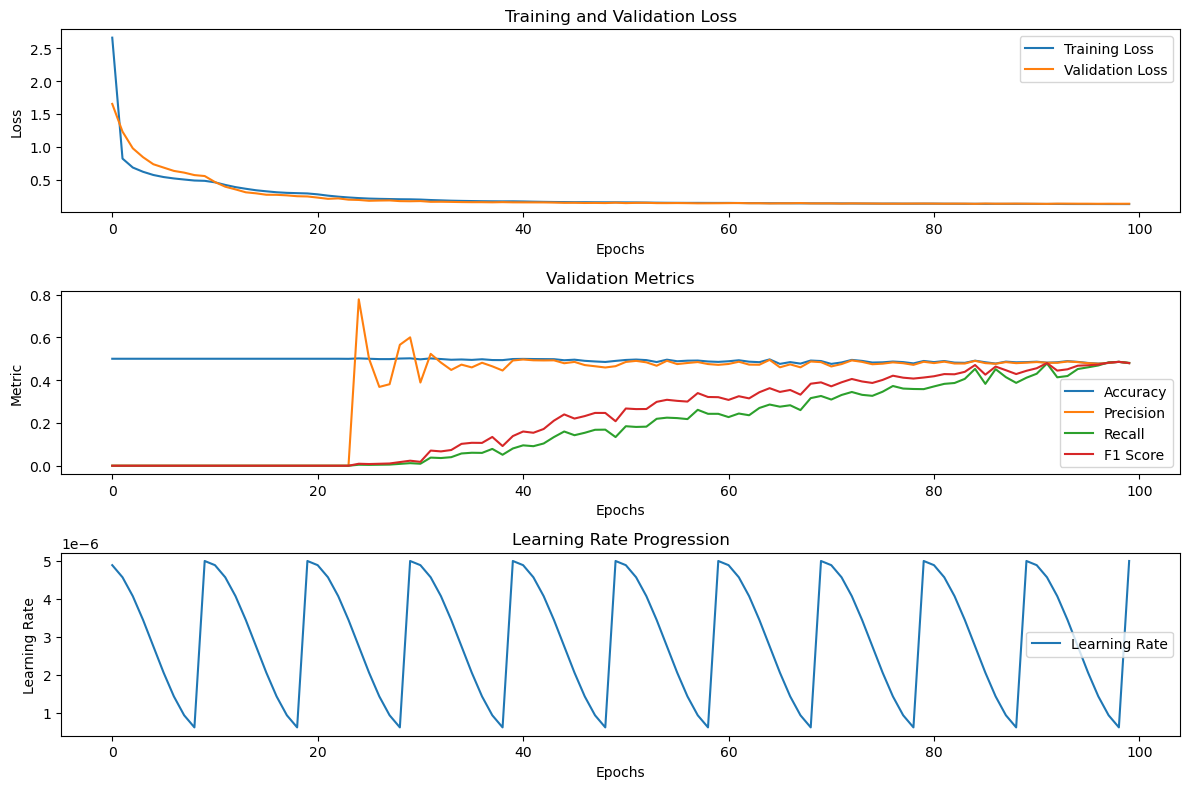

In [514]:
best_text_model, best_image_model = training_method(criterion, optimizer, scheduler, num_epochs=100, train_loader=train_dataloader, val_loader=val_dataloader)

In [515]:
def make_submission(test_loader, text_model, image_model):
    image_model.eval()
    text_model.eval()
    ids = []
    predictions = []

    with torch.no_grad():
        for batch in tqdm(test_loader):
            images = batch['images'].to(device)
            captions = batch['captions'].to(device)
            id = batch['id']

            img_features = image_model(images)
            txt_features = text_model(captions)
            # Compute distances and predictions
            distances = torch.norm(img_features - txt_features, p=2, dim=1)
            preds = (distances < 0.5).int()

            ids.extend(id)
            predictions.extend(preds.cpu().tolist())
    df = pd.DataFrame({'id': ids, 'label': predictions})
    df.to_csv('submission5.csv', index=False) 
    # TODO: 
    #  1.Send submission4.csv
    #  2.Test with spell corection

In [516]:
# # LOAD MODEL FROM PATH
# model_config = {
# ADD
# }
# model = ImageTextClassifier(**model_config)
# model_path = "vocab_size=3733+embedding_dim=128+num_filters=128+filter_sizes=[3, 4, 5, 6, 7, 8]+seq_len=53+cnn_text_drop_value=0.5+cnn_dropout_value=0.4+head_dropout_value=0.5+num_classes=1+eval_loss=0.6202353974606128.pt"
# model.load_state_dict(torch.load(model_path, weights_only=True))
# model.to(device)

In [517]:
make_submission(test_dataloader, best_text_model, best_image_model)

100%|██████████| 125/125 [00:04<00:00, 30.11it/s]


In [518]:

def hyperparameter_tuning(vocab_size, max_len, train_loader, val_loader, param_grid, training_method, num_epochs=200):
    # Create all combinations of hyperparameters
    keys, values = zip(*param_grid.items())
    param_combinations = [dict(zip(keys, v)) for v in product(*values)]

    for params in tqdm(param_combinations):
        print(f"Testing configuration: {params}")

        try:
            # Update model configuration
            model_config = {
                "vocab_size": vocab_size,
                "embedding_dim": params["embedding_dim"],
                "num_filters": params["num_filters"],
                "filter_sizes": params["filter_sizes"],
                "seq_len": max_len,
                "cnn_text_drop_value": params["cnn_text_drop_value"],
                "cnn_dropout_value": params["cnn_dropout_value"],
                "head_dropout_value": params["head_dropout_value"],
            }

            # Initialize model
            model = ImageTextClassifier(**model_config)
            model.to(device)
            model.apply(initialize_weights)

            # Define criterion, optimizer, and scheduler
            criterion = nn.BCEWithLogitsLoss()
            optimizer = optim.AdamW(
                model.parameters(),
                lr=params["lr"],
                weight_decay=params["weight_decay"]
            )
            scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
                optimizer,
                T_0=params["T_0"],
                eta_min=params["eta_min"],
            )

            # Train the model
            training_method(
                model, criterion, optimizer, scheduler,
                num_epochs=num_epochs,
                train_loader=train_loader,
                val_loader=val_loader
            )
            print(f"Completed configuration: {params}")

        except RuntimeError as e:
            print(f"Error with configuration: {params}")
            print(f"Error message: {str(e)}")

        finally:
            # Reset GPU memory
            print("Resetting GPU memory...")
            torch.cuda.empty_cache()
            gc.collect()

In [519]:
param_grid = {
    "embedding_dim": [128],
    "num_filters": [16],
    "filter_sizes": [[3, 4, 5], [3, 4, 5, 6, 7, 8, 9]],
    "head_dropout_value": [0.5],
    "cnn_text_drop_value": [0.5],
    "cnn_dropout_value": [0.5],
    "lr": [1e-5, 1e-4, 5e-4, 1e-3, 5e-3],  # Learning rate candidates
    "weight_decay": [1e-6, 1e-5, 1e-4, 1e-3],  # Weight decay candidates
    "T_0": [10],  # Number of epochs for the first cycle
    "T_mult": [1],  # Cycle multiplier
    "eta_min": [1e-6, 1e-5, 1e-4],  # Minimum learning rate
}

total_combinations = math.prod(len(values) for values in param_grid.values())
print(f"Total combinations: {total_combinations}")

time_per_epoch = 23  # seconds
num_epochs = 100  # epochs per configuration
total_time_seconds = total_combinations * time_per_epoch * num_epochs

# Convert to hours
total_time_hours = total_time_seconds / 3600
print(f"Total time to hyper tune: {total_time_hours} hours")

Total combinations: 120
Total time to hyper tune: 76.66666666666667 hours


In [520]:
results = hyperparameter_tuning(
    vocab_size=len(vocab),
    max_len=max_len,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    param_grid=param_grid,
    training_method=training_method,
    num_epochs=100
)

  0%|          | 0/120 [00:00<?, ?it/s]

Testing configuration: {'embedding_dim': 128, 'num_filters': 16, 'filter_sizes': [3, 4, 5], 'head_dropout_value': 0.5, 'cnn_text_drop_value': 0.5, 'cnn_dropout_value': 0.5, 'lr': 1e-05, 'weight_decay': 1e-06, 'T_0': 10, 'T_mult': 1, 'eta_min': 1e-06}
Resetting GPU memory...


  0%|          | 0/120 [00:00<?, ?it/s]


NameError: name 'ImageTextClassifier' is not defined

In [ ]:
dir_models = os.listdir("./models")

In [ ]:
best_models = [path[:-3] for path in dir_models if path.endswith(".pt")]

In [ ]:
best_val_loss = [float(str(best_model.split("+")[-1:]).split("=")[1][:8]) for best_model in best_models]

In [ ]:
best_val_loss.sort()
best_val_loss[:100]